## Install TensorTrade

In [ ]:
!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

## Setup Data Fetching

In [207]:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent

import talib
from talib import stream

%matplotlib inline

In [208]:
cdd = CryptoDataDownload()

data = cdd.fetch("Bitstamp", "USD", "ETH", "1h")

In [209]:
data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
#data['sma_low'] = talib.SMA(data['close'], timeperiod=200)
#data['sma_high'] = talib.SMA(data['close'], timeperiod=50)
data["slowk"], data["slowd"] = talib.STOCHF(data['high'], data['low'], data['close'], fastk_period=5, fastd_period=3, fastd_matype=0)
data['chaikin'] = talib.AD(data['high'], data['low'], data['close'], data['volume'])

data.head()

,date,unix,open,high,low,close,volume,macd,macd_signal,macd_hist,slowk,slowd,chaikin
0,2018-05-15 06:00:00,1526364000,732.10,736.67,730.94,733.00,1043.91,NaN,NaN,NaN,NaN,NaN,-293.315026
1,2018-05-15 07:00:00,1526367600,733.00,735.99,730.45,733.82,353.82,NaN,NaN,NaN,NaN,NaN,-216.675315
2,2018-05-15 08:00:00,1526371200,733.82,734.92,721.58,731.68,3924.55,NaN,NaN,NaN,NaN,NaN,1801.496574
3,2018-05-15 09:00:00,1526374800,731.68,731.82,726.98,727.32,601.03,NaN,NaN,NaN,NaN,NaN,1284.908805
4,2018-05-15 10:00:00,1526378400,727.32,739.37,725.04,733.59,1943.15,NaN,NaN,NaN,NaN,NaN,1660.521192


## Create features with the feed module

In [226]:
from tensortrade.features import FeaturePipeline
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features.indicators import SimpleMovingAverage
from tensortrade.features.indicators import TAlibIndicator
price_columns = ["open", "high", "low", "close"]
normalize_price = MinMaxNormalizer(price_columns)
moving_averages = SimpleMovingAverage(price_columns)
difference_all = FractionalDifference(difference_order=0.6)
feature_pipeline = FeaturePipeline(steps=[normalize_price,
                                          moving_averages,
                                          difference_all])
#exchange.feature_pipeline = feature_pipeline

In [220]:
from talib import abstract
macd = abstract.Function('macd')

def rsi(price: Stream[float], period: float) -> Stream[float]:
    r = price.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def tech_indicator(price: Stream[float]) -> Stream[float]:
    signal = price.apply(talib.MACD)
    return signal

def feedProxy(price: Stream[float], name) -> Stream[float]:
    out = Stream.select(features, lambda s: [name])
    return out

features = []

#for c in data.columns[1:]:
for c in ["high","close","slowd","chaikin"]:
    s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
    features += [s]

    #["high,","close","low","macd","chaikin"]
cp = Stream.select(features, lambda s: ["chaikin","close"])
slowd = feedProxy(cp,"slowd").rename("slowd")
chaikin = feedProxy(cp,"chaikin").rename("chaikin")


self.stoc = bt.talib.STOCH(self.data.high, self.data.low, self.data.close,
                                   fastk_period=14, slowk_period=3, slowd_period=3)


features = [
    cp.log().diff().rename("learning_rate"),
    rsi(cp, period=20).rename("rsi"),
    macd(cp, fast=10, slow=50, signal=5).rename("macd"),
    tech_indicator(cp)
    
]
features.append(chaikin)
features.append(slowd)

print(features)

feed = DataFeed(features)
feed.compile()

TypeError: 'IterableStream' object is not iterable

In [221]:
for i in range(5):
    print(feed.next())

TypeError: Argument 'real' has incorrect type (expected numpy.ndarray, got float)

## Setup Trading Environment

In [ ]:

def generate_features(data):
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

    for strategy in strategies:
        df.ta.study(strategy, exclude=['kvo'])

    df = df.set_index('date')

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [120]:
bitstamp = Exchange("bitstamp", service=execute_order)(
    Stream.source(list(data["close"]), dtype="float").rename("USD-ETH")
)

portfolio = Portfolio(USD, [
    Wallet(bitstamp, 10000 * USD),
    Wallet(bitstamp, 10 * ETH)
])


renderer_feed = DataFeed([
    Stream.source(list(data["date"])).rename("date"),
    Stream.source(list(data["open"]), dtype="float").rename("open"),
    Stream.source(list(data["high"]), dtype="float").rename("high"),
    Stream.source(list(data["low"]), dtype="float").rename("low"),
    Stream.source(list(data["close"]), dtype="float").rename("close"), 
    Stream.source(list(data["volume"]), dtype="float").rename("volume") 
])


env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=20
)

In [121]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-ETH': 733.0,
  'bitstamp:/USD:/free': 10000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 10000.0,
  'bitstamp:/ETH:/free': 10.0,
  'bitstamp:/ETH:/locked': 0.0,
  'bitstamp:/ETH:/total': 10.0,
  'bitstamp:/ETH:/worth': 7330.0,
  'net_worth': 17330.0},
 'external': {'learning_rate': nan,
  'rsi': nan,
  'macd': 0,
  'slowd': 1526364000},
 'renderer': {'date': Timestamp('2018-05-15 06:00:00'),
  'open': 732.1,
  'high': 736.67,
  'low': 730.94,
  'close': 733.0,
  'volume': 1043.91}}

## Setup and Train DQN Agent

/usr/local/lib/python3.9/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



FigureWidget({
    'data': [{'close': array([733.  , 733.82, 731.68, ..., 626.25, 618.97, 616.79]),
          …

/usr/local/lib/python3.9/dist-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



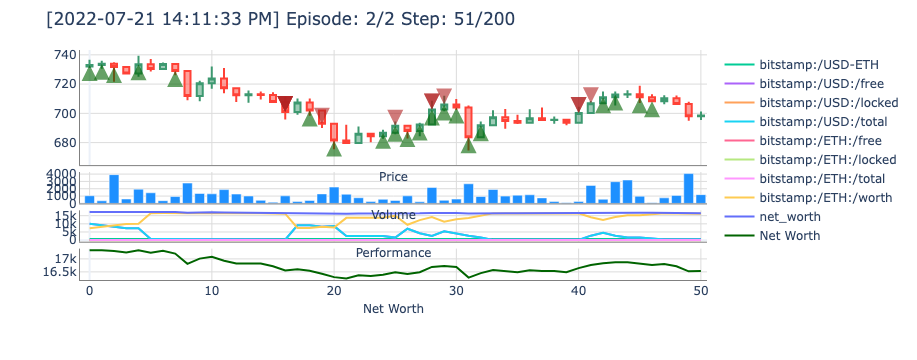

/usr/local/lib/python3.9/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



FigureWidget({
    'data': [{'close': array([733.  , 733.82, 731.68, 727.32, 733.59, 730.24, 733.8 , 728.96, 7…

/usr/local/lib/python3.9/dist-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



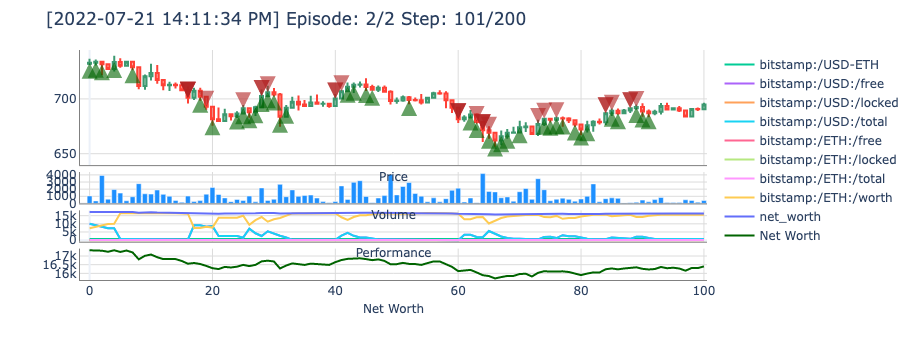

/usr/local/lib/python3.9/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



FigureWidget({
    'data': [{'close': array([733.  , 733.82, 731.68, 727.32, 733.59, 730.24, 733.8 , 728.96, 7…

/usr/local/lib/python3.9/dist-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



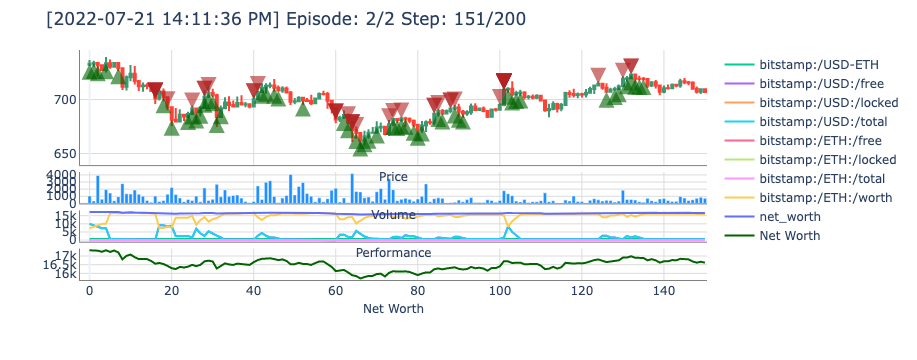

/usr/local/lib/python3.9/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



FigureWidget({
    'data': [{'close': array([733.  , 733.82, 731.68, 727.32, 733.59, 730.24, 733.8 , 728.96, 7…

/usr/local/lib/python3.9/dist-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



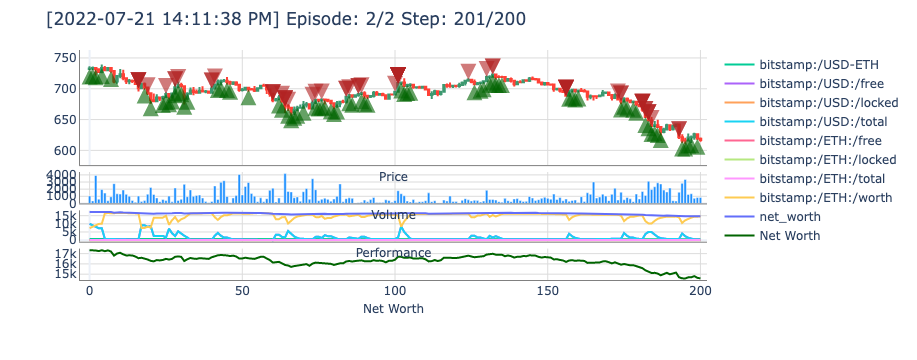

-1828185.3362565842

In [122]:
agent = DQNAgent(env)

agent.train(n_steps=200, n_episodes=2, save_path="agents/")